In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import numpy as np

import utils.windFarms as wfman
from utils.networks import GraphNeuralNet as GNN
from utils.graphNetHelpers import graph2inputs
from utils.testUtils import test_direction, test_speed, test_speed_direction, pprint_graph

import torch

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt

In [5]:
angle_threshold = 90

In [6]:
save_path = '../pib_saves/pib8'

gnn_load = GNN.load(save_path, device='cpu')
gnn_load.eval()

GraphNeuralNet(
  (layers): ModuleList(
    (0): GraphNetworkBlock(
      (encoders): ModuleList(
        (0): MultiLayerPerceptron(
          (layers): ModuleList(
            (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=8, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=128, bias=True)
            (4): Linear(in_features=128, out_features=50, bias=True)
          )
        )
        (1): MultiLayerPerceptron(
          (layers): ModuleList(
            (0): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=54, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=128, bias=True)
            (4): Linear(in_features=128, out_features=50, bias=True

In [7]:
x_grid_size = 2000
y_grid_size = 2000
base_config_path = '../configs/example_input_JK100.json'
update_config_path = '../configs/update_floris_configs.json'
single_input_path = '../configs/example_input_single.json'
min_distance_factor = 2.0

wind_farm_man = wfman.RandomSampleManager(x_grid_size=x_grid_size,
                                          y_grid_size=y_grid_size,
                                          update_config_json_path=update_config_path,
                                          base_config_json_path=base_config_path,
                                          single_input_path=single_input_path,
                                          angle_threshold=angle_threshold,
                                          min_distance_factor=min_distance_factor,
                                          dist_cutoff_factor=25)

In [8]:
use_power = True

In [9]:
wind_farm_man.sample_wind_farm(5)

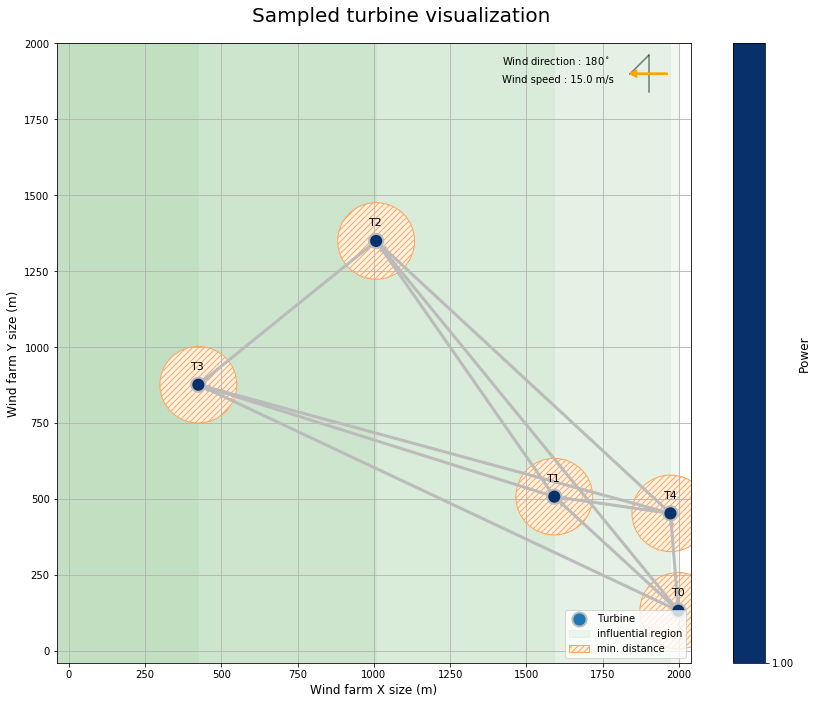

In [10]:
wind_farm_man.update_wind_farm_graph(wind_speed=15.0, wind_direction=180)
wind_farm_man.visualize_wind_farm()

In [12]:
layer_index = 2

x, y = wind_farm_man.observe()
x_viz = wind_farm_man.observe_viz()
attention = gnn_load.get_attention([x], layer_index=layer_index)

In [13]:
gnn_load.test([x],[y])

array(0.00224328, dtype=float32)

In [14]:
pos_dict = dict()
for n in x_viz.nodes:
    pos_dict[n] = np.array(x_viz.nodes[n]['coords'])

In [15]:
attn_net = gnn_load.layers[2].encoders[3]

In [16]:
attn_net.norm.mean, attn_net.norm.std, attn_net.norm.w, attn_net.norm.b

(tensor([398.3580, 577.0497,  10.4858]),
 tensor([359.7601, 462.4511,   3.7808]),
 Parameter containing:
 tensor([0.9961, 0.9942, 1.0000], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [17]:
x_pred = gnn_load([x])

In [18]:
attn_min = 0
attn_max = 0

attns = []
for e in attention[0].edges():
    attn = attention[0].edges[e]['attention'].detach().numpy()[0]
    attns.append(attn)

In [19]:
layer_indices = [0,1,2]
attentions = []
for i in layer_indices:
    try:
        attention = gnn_load.get_attention([x], layer_index=i)
        attentions.append(attention)
    except:
        pass

In [20]:
inp = torch.Tensor([[100, 0, 15.0],[100, 10, 15.0]])
#inp = torch.Tensor([[200, 50, 10.0],[200, 100, 10.0],[200, 150, 10.0]])
#inp = torch.Tensor([[200, 30, 10.0],[300, 30, 10.0],[400, 30, 10.0]])

attn_net(inp)

tensor([[0.6193],
        [0.6191]], grad_fn=<ReluBackward>)

In [21]:
attn_net.norm.mean, attn_net.norm.var, attn_net.norm.std

(tensor([398.3580, 577.0497,  10.4858]),
 tensor([129427.3281, 213861.0000,     14.2943]),
 tensor([359.7601, 462.4511,   3.7808]))

In [22]:
attn_net.norm.w

Parameter containing:
tensor([0.9961, 0.9942, 1.0000], requires_grad=True)

In [23]:
attn_net.alpha, attn_net.r0, attn_net.k

(Parameter containing:
 tensor([1.0056], requires_grad=True), Parameter containing:
 tensor([1.0055], requires_grad=True), Parameter containing:
 tensor([0.9961], requires_grad=True))

In [24]:
attention_vs = []
for e in attention[0].edges():
    #print(attention[0].edges[e])
    attn = attention[0].edges[e]['attention'].detach().numpy()[0]
    attention_vs.append(attn)

In [25]:
attention_vs

[0.19454193,
 0.04456127,
 0.03254446,
 0.5815683,
 0.09204373,
 0.05504335,
 0.12796476,
 0.23989026,
 0.057376206,
 0.035497483]

In [26]:
def normalize(attn_v):
    min_v = 0.4 #min(attention_vs)
    max_v = max(attention_vs)

    return (attn_v - min_v) / (max_v - min_v)
    
    #min(attention_vs), max(attention_vs)

In [27]:
cmap = matplotlib.cm.Blues
norm = matplotlib.colors.Normalize(vmin =0, vmax=1.0)

num_fig = len(layer_indices)

fig, ax = plt.subplots(num_fig,1, figsize=(5,15))


for i in layer_indices[:1]:
    ax[i].set_xlim(-100,x_grid_size+100)
    ax[i].set_ylim(-100,y_grid_size+100)
    nx.draw_networkx_nodes(attention[0], pos_dict, 
                           node_color='#f88379',
                           node_size=300, ax=ax[i])

    # edges
    for e in attentions[i][0].edges():    
        attn = attentions[i][0].edges[e]['attention'].detach().numpy()[0]
        
        #dj_attn = np.log(attn) + 12
        print(e, attn)
        r, g, b, a = cmap(attn)
        c = np.array([r, g, b, a]).reshape(1, -1)
        nx.draw_networkx_edges(attention[0], 
                               pos_dict, 
                               edgelist=[e], 
                               width=attn*10,
                               alpha=1.0, 
                               #width=3.0, 
                               edge_color=c,
                               ax=ax[i])
    print('\n')

(0, 1) 0.19454193
(0, 2) 0.04456127
(0, 3) 0.03254446
(0, 4) 0.5815683
(1, 2) 0.09204373
(1, 3) 0.05504335
(2, 3) 0.12796476
(4, 1) 0.23989026
(4, 2) 0.057376206
(4, 3) 0.035497483


